In [1]:
import tables, glob, os, time, sys
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.colors as colors
from scipy.stats import norm

In [2]:
def ReadFile(Keys, File): 
    if not os.path.isfile(File):
        print('no')
        return
    else: 
        Data = {}
        try:
            with tables.open_file(File, mode="r") as f: 
                for Key in Keys:    
                    data = f.root._f_get_child(Key)._f_get_child(Key).read()
                    if data is None:
                        print(data)
                    Data[Key] = data
            if Data is None: 
                print(Data)
            return(Data)
        except:
            return 

In [3]:
def GetPhotonFlags(Flags):
    PhotonFlags = {}
    PhotonFlags['NO_HIT'] = (Flags & (0x1 << 0)).astype(bool)   
    PhotonFlags['BULK_ABSORB'] = (Flags & (0x1 << 1)).astype(bool)   
    PhotonFlags['SURFACE_DETECT'] = (Flags & (0x1 << 2)).astype(bool)   
    PhotonFlags['SURFACE_ABSORB'] = (Flags & (0x1 << 3)).astype(bool)   
    PhotonFlags['RAYLEIGH_SCATTER'] = (Flags & (0x1 << 4)).astype(bool)   
    PhotonFlags['REFLECT_DIFFUSE'] = (Flags & (0x1 << 5)).astype(bool)   
    PhotonFlags['REFLECT_SPECULAR'] = (Flags & (0x1 << 6)).astype(bool)    
    PhotonFlags['SURFACE_REEMIT'] = (Flags & (0x1 << 7)).astype(bool)    
    PhotonFlags['SURFACE_TRANSMIT'] = (Flags & (0x1 << 8)).astype(bool)    
    PhotonFlags['BULK_REEMIT'] = (Flags & (0x1 << 9)).astype(bool)   
    PhotonFlags['MATERIAL_REFL'] = (Flags & (0x1 << 10)).astype(bool)  
    PhotonFlags['NAN_ABORT'] = (Flags & (0x1 << 31)).astype(bool)  
    return PhotonFlags

In [10]:
Keys1 = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 
                        'Flags', 'FinalPosition', 'NumDetected', 'InitialPosition', 'DetectedPos']#, 'OpticalParameters']

# File1 = "..\chroma_nEXO_OD_OD_test_210527_164627_r3326.h5"
# File1 = "..\chroma_nEXO_OD_OD_test_210528_114859_r7131.h5"
# File1 = 'chroma_nEXO_OD_OD_test_210614_150559_r5036.h5'

#Z beam straight down with one PMT in center bottom
# File1 = 'chroma_nEXO_OD_OD_test_210615_095507_r6011.h5'
# File1 = 'chroma_nEXO_OD_OD_test_210615_095856_r4567.h5'

#cherenkov source, pos [0,0,-3400], straight down
File1 = 'h5_files/chroma_nEXO_OD_OD_test_210615_133245_r2794.h5'
#cherenkov source, pos [0,0,-3400], at corner [0,-1,-1]
File1 = 'h5_files/chroma_nEXO_OD_OD_test_210615_133535_r3926.h5'
#cherenkov source, pos [0,0,-3400], at corner [0,-1,-1], more photons and path length 4000 mm
File1 = 'h5_files/chroma_nEXO_OD_OD_test_210615_145704_r5508.h5'


Data1 = ReadFile(Keys1, File1)

In [11]:
print(Data1.keys())

# for var in Data1.keys():
#     print(var, "- number of entries:", len(Data1[var]))
#     print("     ", Data1[var], '\n')

dict_keys(['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 'Flags', 'FinalPosition', 'NumDetected', 'InitialPosition', 'DetectedPos'])


## Plotting final positions

In [12]:
finalPos = Data1['FinalPosition']
# finalPos[:,0]

topHeight = 5000
bottomHeight = -5000
radius = 6000

#get hits on surfaces
top = []
bottom = []
side = []
all_sides = []
skipped = 0

flagTag = GetPhotonFlags(Data1['Flags'])
# print(flagTag)

for i, pos in enumerate(finalPos):
    if flagTag['BULK_ABSORB'][i]: #don't save any photons that are absorbed in the water
#         print("skip")
        skipped +=1
    else:
        x,y,z = pos
        R = np.sqrt(x*x + y*y)
        Az = np.arctan(y/x)
        
#         print([x,y,z], [R, Az, z])
        
        #save photons that stopped only near the edge of the WT - to be improved later
        if z >= topHeight:
            top.append([x,y])
            all_sides.append([x,y,z])
        elif z <= bottomHeight:
            bottom.append([x,y])
            all_sides.append([x,y,z])
        elif R > radius:
            side.append([Az, z])
            all_sides.append([x,y,z])
            
top = np.array(top).T
bottom = np.array(bottom).T
side = np.array(side).T
all_sides = np.array(all_sides).T

<ipython-input-12-a346f1d93f7c>:25: RuntimeWarning: divide by zero encountered in float_scalars
  Az = np.arctan(y/x)


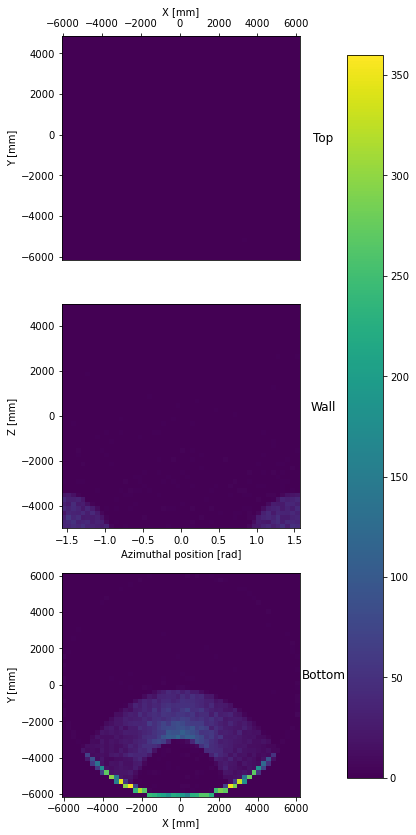

In [13]:
# print( bottom)

fig, axes = plt.subplots(3, 1, figsize=(6,14))

Colmap=plt.get_cmap('viridis')
binsize = (50, 50)

#### top of watertank #####
hist1 = axes[0].hist2d(top[0], top[1], bins=binsize, cmap=Colmap)
axes[0].set_xlabel("X [mm]")
axes[0].set_ylabel("Y [mm]")
# axes[0].tick_params(labelbottom=False,labeltop=True)
axes[0].xaxis.set_ticks_position('top') 
axes[0].xaxis.set_label_position('top')
axes[0].set_title('Top', x =1.1, y=0.5,)

#### wall of watertank #####
#Azimuthal position [rad]

hist2 = axes[1].hist2d(side[0], side[1], bins=binsize, cmap=Colmap)
axes[1].set_xlabel("Azimuthal position [rad]")
axes[1].set_ylabel("Z [mm]")
axes[1].set_title('Wall', x =1.1, y=0.5,)


#### bottom of watertank #####
hist3 = axes[2].hist2d(bottom[0], bottom[1], bins=binsize, cmap=Colmap)
axes[2].set_xlabel("X [mm]")
axes[2].set_ylabel("Y [mm]")
axes[2].set_title('Bottom', x =1.1, y=0.5,)

# # Find the min and max of all colors for use in setting the color scale.
images = [hist1[-1], hist2[-1], hist3[-1]]
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
    
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.2)

cbar = fig.colorbar(images[0], ax=axes, shrink=0.95, pad=.14)
# cbar.set_ticks(np.arange(0, 1.1, 0.5))
# cbar.set_ticklabels(['low', 'medium', 'high'])
plt.show()

In [14]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

p = axes.scatter3D(all_sides[0], all_sides[1], all_sides[2], s=.5)

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(20, 30)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()

NameError: name 'mplot3d' is not defined

<Figure size 504x504 with 0 Axes>

## Looking at photon paths

In [ ]:
from stl import mesh
from mpl_toolkits import mplot3d

In [ ]:
I_pos = Data1['InitialPosition'].T
f_pos = Data1['FinalPosition'].T  

In [ ]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(I_pos[0], I_pos[1], I_pos[2], 'blue')
axes.scatter3D(f_pos[0], f_pos[1], f_pos[2], 'red', alpha=0.3)


# for i in range(len(paths)):
#     direction = np.arange(len(paths[i][0]))#, len(paths[i][0]))

#     axes.plot3D(paths[i][0], paths[i][1], paths[i][2], 'blue', alpha=0.4)
#     p = axes.scatter3D(paths[i][0], paths[i][1], paths[i][2], c=direction, cmap='viridis') #, vmin=0, vmax=ELs_max)
    
#     print(paths[i][0][1], paths[i][1][1], paths[i][2][1])    

# axes.set_xlim3d(-100, 100)
# axes.set_ylim3d(-100, 100)
# axes.set_zlim3d(-3600, -3200)

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

# axes.legend()

# fig.colorbar(p, label="Step Number", shrink=0.8)

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(20, 20)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()

# PMT_MetalConnection PMT_Glassware

In [15]:
# for f in Data1['Flags']:
    
flagTag = GetPhotonFlags(Data1['Flags'])

bars = np.zeros(len(flagTag.keys()))
for i, var in enumerate(flagTag.keys()):
    bars[i] = flagTag[var].sum()

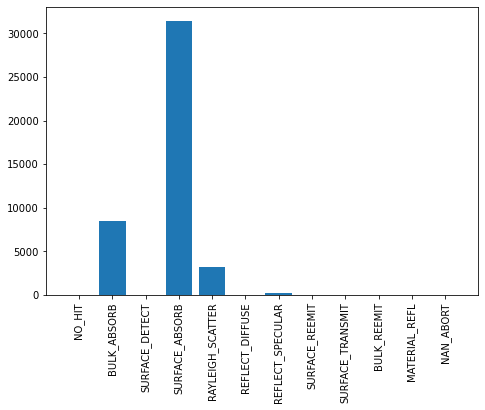

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(flagTag.keys(),bars)
plt.xticks(rotation=90)
plt.show()

In [14]:
np.array([1,2,0,3,4]).nonzero()

(array([0, 1, 3, 4], dtype=int64),)